In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [0]:
trainX = np.array(((0,0,0),(0,0,1),(0,1,0),(0,1,1),(1,0,0),(1,0,1),(1,1,0),(1,1,1)))
trainY = np.array((0,0,0,0,0,0,0,1))

In [658]:
print("TrainX shape: " +str(trainX.shape))
print("TrainY shape: " +str(trainY.shape))

TrainX shape: (8, 3)
TrainY shape: (8,)


In [659]:
trainX = trainX.transpose()

trainY = trainY.reshape(1,trainY.shape[0])

print("TrainX shape: " +str(trainX.shape))
print("TrainY shape: " +str(trainY.shape))

#Making X's shape as nx*m and Y's shape as 1*m

TrainX shape: (3, 8)
TrainY shape: (1, 8)


In [660]:
layers = np.array((trainX.shape[0],30,20,10,5,trainY.shape[0]))

print("Model has " +str(layers.shape[0])+ " Layers")
for i in range(1,layers.shape[0]):
  print("Layer " +str(i)+ " has " +str(layers[i])+ " Nodes")

Model has 6 Layers
Layer 1 has 30 Nodes
Layer 2 has 20 Nodes
Layer 3 has 10 Nodes
Layer 4 has 5 Nodes
Layer 5 has 1 Nodes


In [0]:
def randomMiniBatch(m, mini_batch_size, trainX, trainY):

  m = trainX.shape[1]                  
  mini_batches = []

  permutations = list(np.random.permutation(m))

  trainX_shuffled = trainX[:, permutations]
  trainY_shuffled = trainY[:, permutations]

  num_minibatch = math.floor(m/mini_batch_size)

  for i in range(0, num_minibatch):

    mini_batch_X = trainX_shuffled[:, i*mini_batch_size : (i+1)*mini_batch_size]
    mini_batch_Y = trainY_shuffled[:, i*mini_batch_size : (i+1)*mini_batch_size]

    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)

  if m % mini_batch_size != 0:

    mini_batch_X = trainX_shuffled[:,num_minibatch * mini_batch_size:]
    mini_batch_Y = trainY_shuffled[:,num_minibatch * mini_batch_size:]

    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)

  return mini_batches

In [0]:
def initialiseWeights(layers):
  #Random Initialisation

  L = len(layers)
  param={}

  for i in range(1,L):
    param["W"+str(i)] = np.random.randn(layers[i], layers[i-1]) * 0.5
    param["b"+str(i)] = np.zeros((layers[i],1))

  return param

In [0]:
def initialiseVelocity(param):

  L = len(param)//2
  S = {}

  for i in range(L):

    W = param["W"+str(i+1)]
    b = param["b"+str(i+1)]

    S["dW"+str(i+1)] = np.zeros((W.shape[0],W.shape[1]))
    S["db"+str(i+1)] = np.zeros((b.shape[0],b.shape[1]))

  return S

In [0]:
def forwardActivation(A_prev, W, b, activation):

  Z = np.dot(W,A_prev) + b
  l_cache = (A_prev,W,b)

  if activation == "relu":
    A = np.maximum(Z,0)
    a_cache = (A,Z)

  if activation == "sigmoid":
    A = 1/(1+np.exp(-Z))
    a_cache = (A,Z)

  cache = (l_cache,a_cache)

  return A,cache

In [0]:
def forwardPropogation(X, param):

  L = len(param)//2
  A = X
  caches = []

  for i in range(1,L):
    #Relu Activation
    A_prev = A
    W = param["W" +str(i)]
    b = param["b" +str(i)]
    A ,cache = forwardActivation(A_prev, W, b, activation="relu")
    caches.append(cache)
    
  #Sigmoid Activation
  W = param["W" +str(L)]
  b = param["b" +str(L)]
  A_last_layer ,cache = forwardActivation(A, W, b, activation="sigmoid")
  caches.append(cache)

  return A_last_layer , caches

In [0]:
def computeCost(A, Y):

  loss = -np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))

  return loss

In [0]:
def backwardActivation(dA, Y ,cache ,activation):

  l_cache, a_cache = cache
  A_prev , W , b = l_cache
  A , Z = a_cache

  if activation == "relu":
    dZ = np.multiply(dA, np.int64(A > 0))

  if activation == "sigmoid":
    dZ = dA - Y

  dW = np.dot(dZ ,A_prev.T)/m
  db = np.sum(dZ ,axis=1 ,keepdims=True)
  dA_prev = np.dot(W.T ,dZ)

  return dA_prev, dW , db

In [0]:
def backwardPropogation(A, Y, caches):

  grads = {}
  L = len(caches)
  m = A.shape[1]

  dALL = -(np.divide(Y,A) - np.divide((1-Y),(1-A)))

  #Last layer
  last_layer_cache = caches[-1]
  dA,dW,db = backwardActivation(dALL ,Y ,last_layer_cache ,activation="sigmoid")
  grads["dA" +str(L-1)] = dA
  grads["dW" +str(L)] = dW
  grads["db" +str(L)] = db

  for i in reversed(range(L-1)):

    layer_cache = caches[i]
    
    dA_next_layer = grads["dA" +str(i+1)]
    dA,dW,db = backwardActivation(dA_next_layer ,Y ,layer_cache ,activation="relu")
    grads["dA" +str(i)] = dA
    grads["dW" +str(i+1)] = dW
    grads["db" +str(i+1)] = db

  return grads

In [0]:
def optimizeWithRMS(param, grads, S, beta, epsilon, lr):

  L = len(param)//2
  v_corrected = {}
  s_corrected = {}  

  for i in range(L):

    S["dW" +str(i+1)] = (beta*S["dW" +str(i+1)]) + ((1-beta)*np.square(grads["dW"+str(i+1)]))
    S["db" +str(i+1)] = (beta*S["db" +str(i+1)]) + ((1-beta)*np.square(grads["db"+str(i+1)]))
    #Using formula S = beta*V + (1-beta)*Theta^2

    param["W" +str(i+1)] = param["W" +str(i+1)] - lr*(grads["dW"+str(i+1)]/np.sqrt(S["dW" +str(i+1)] + epsilon))
    param["b" +str(i+1)] = param["b" +str(i+1)] - lr*(grads["db"+str(i+1)]/np.sqrt(S["db" +str(i+1)] + epsilon))
    #Using Formula W = W - alpha*dW/(S_corrected + epsilon ** 1/2)

  return param, V

0.7798360827813211
0.3845625301371963
0.18485850330403716
0.12520560273026823
0.09348105071016302
0.06883121541955672
0.052754092817661066
0.0464742325787963
0.04398048028120136


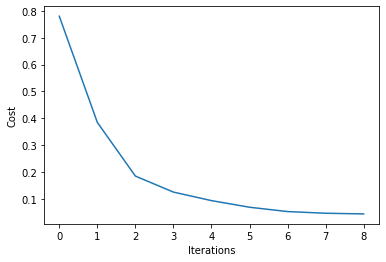

In [695]:
m = trainX.shape[1]
mini_batch_size = 1
epochs = 450
beta = 0.999
epsilon = 1e-8
learning_rate = 0.00006
cost_plot = []


param = initialiseWeights(layers)
#Initialising Weights

S = initialiseVelocity(param)
#Initialising S for RMS

for i in range(epochs):

  mini_batches = randomMiniBatch(m, mini_batch_size, trainX, trainY)
  #Creating and Randomizing the Mini Batches

  cost = 0

  for mBatch in mini_batches:

    (X, Y) = mBatch

    A_last_layer, caches = forwardPropogation(X, param)

    cost = cost + computeCost(A_last_layer, Y)/m

    grads = backwardPropogation(A_last_layer, Y, caches)

    param, velocity = optimizeWithRMS(param, grads, S, beta, epsilon, learning_rate)

  if i%50==0:
    print(cost)
    cost_plot.append(cost)
  
plt.plot(cost_plot)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.show()

In [696]:
testX = np.array(((0,0,0),(0,0,1),(0,1,0),(0,1,1),(1,0,0),(1,0,1),(1,1,0),(1,1,1)))
testY = np.array((0,0,0,0,0,0,0,1))

testX1 = np.transpose(testX)

accuracy, caches = forwardPropogation(testX1, param)

for i in range(testX.shape[0]):
  difference = 0
  difference = testY[i] - accuracy[0][i]

  if accuracy[0][i] >= 0.5:
    accuracy[0][i] = 1
  else:
    accuracy[0][i] = 0

  print("\tX= " +str(testX[i])+ "\tActual Output= " +str(testY[i])+ "\tPredicted Value= " +str(accuracy[0][i])+ "\tDifference= %.2f" %(abs(difference)))

	X= [0 0 0]	Actual Output= 0	Predicted Value= 0.0	Difference= 0.00
	X= [0 0 1]	Actual Output= 0	Predicted Value= 0.0	Difference= 0.00
	X= [0 1 0]	Actual Output= 0	Predicted Value= 0.0	Difference= 0.00
	X= [0 1 1]	Actual Output= 0	Predicted Value= 0.0	Difference= 0.00
	X= [1 0 0]	Actual Output= 0	Predicted Value= 0.0	Difference= 0.00
	X= [1 0 1]	Actual Output= 0	Predicted Value= 0.0	Difference= 0.00
	X= [1 1 0]	Actual Output= 0	Predicted Value= 0.0	Difference= 0.00
	X= [1 1 1]	Actual Output= 1	Predicted Value= 1.0	Difference= 0.29
